## Part 1 -- Adjusting Time Series

### 1 -- Importing data

In [154]:
from fredapi import Fred
import pandas as pd
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
# API key from FRED: https://fred.stlouisfed.org/docs/api/api_key.html -- 5a72198ba82bfb30d23caa460eb6d4c3
fred = Fred(api_key='5a72198ba82bfb30d23caa460eb6d4c3')
# certificate error fix: 
# https://stackoverflow.com/questions/68275857/urllib-error-urlerror-urlopen-error-ssl-certificate-verify-failed-certifica

# return a Pandas dataframe with only the past `years` years' data
def import_data(ticker, years=20):
    raw_series = fred.get_series(ticker)
    start_date = pd.to_datetime('today') - pd.DateOffset(years=years)
    data = pd.DataFrame(raw_series, columns=['value'])
    return data[data.index >= start_date]

# obtain the manufacturing orders index
data_moi = import_data("UMDMNO")
# .. and the raw materials index
data_rmi = import_data("PRAWMINDEXM")
# .. and the producer price index
data_ppi = import_data("PPIACO")
data_ppi

,value
2004-01-01,141.400
2004-02-01,142.100
2004-03-01,143.100
2004-04-01,144.800
2004-05-01,146.800
...,...
2023-07-01,253.835
2023-08-01,257.674
2023-09-01,258.797
2023-10-01,255.033


### 2 -- Raw data

In [159]:
# calculate spearman autocorrelation between RMI and PPI

# merge dataframes
data_merged = pd.DataFrame(data_rmi)
data_merged["ppi"] = data_ppi
data_merged["moi"] = data_moi
data_merged.rename(columns={"value": "rmi", "ppi": "ppi", "moi": "moi"}, inplace=True)


def calc_lagged_cor(data_merged, index_name1 = "rmi", index_name2 = "ppi"):
    correlations = []
    lags = np.arange(-20,30)
    
    for lag in lags:
        data_lags = pd.DataFrame(data_merged)
    
        # shift ppi data by lag, dropping the NA values this creates
        data_lags[index_name2+"-lag-"+str(lag)] = data_merged[index_name2].shift(lag)
        data_lags = data_lags.dropna()
        
        # calculate spearman autocorrelation, returns autocorr and p-value
        corr, p_value = spearmanr(data_lags[index_name1],data_lags[index_name2+"-lag-"+str(lag)])
        
        correlations.append(corr)
    return correlations, lags, data_lags

correlations, lags, data_lags = calc_lagged_cor(data_merged)
# find maximum correlation
max_corr = np.max(correlations)
max_lag = lags[np.where(correlations == max_corr)][0]

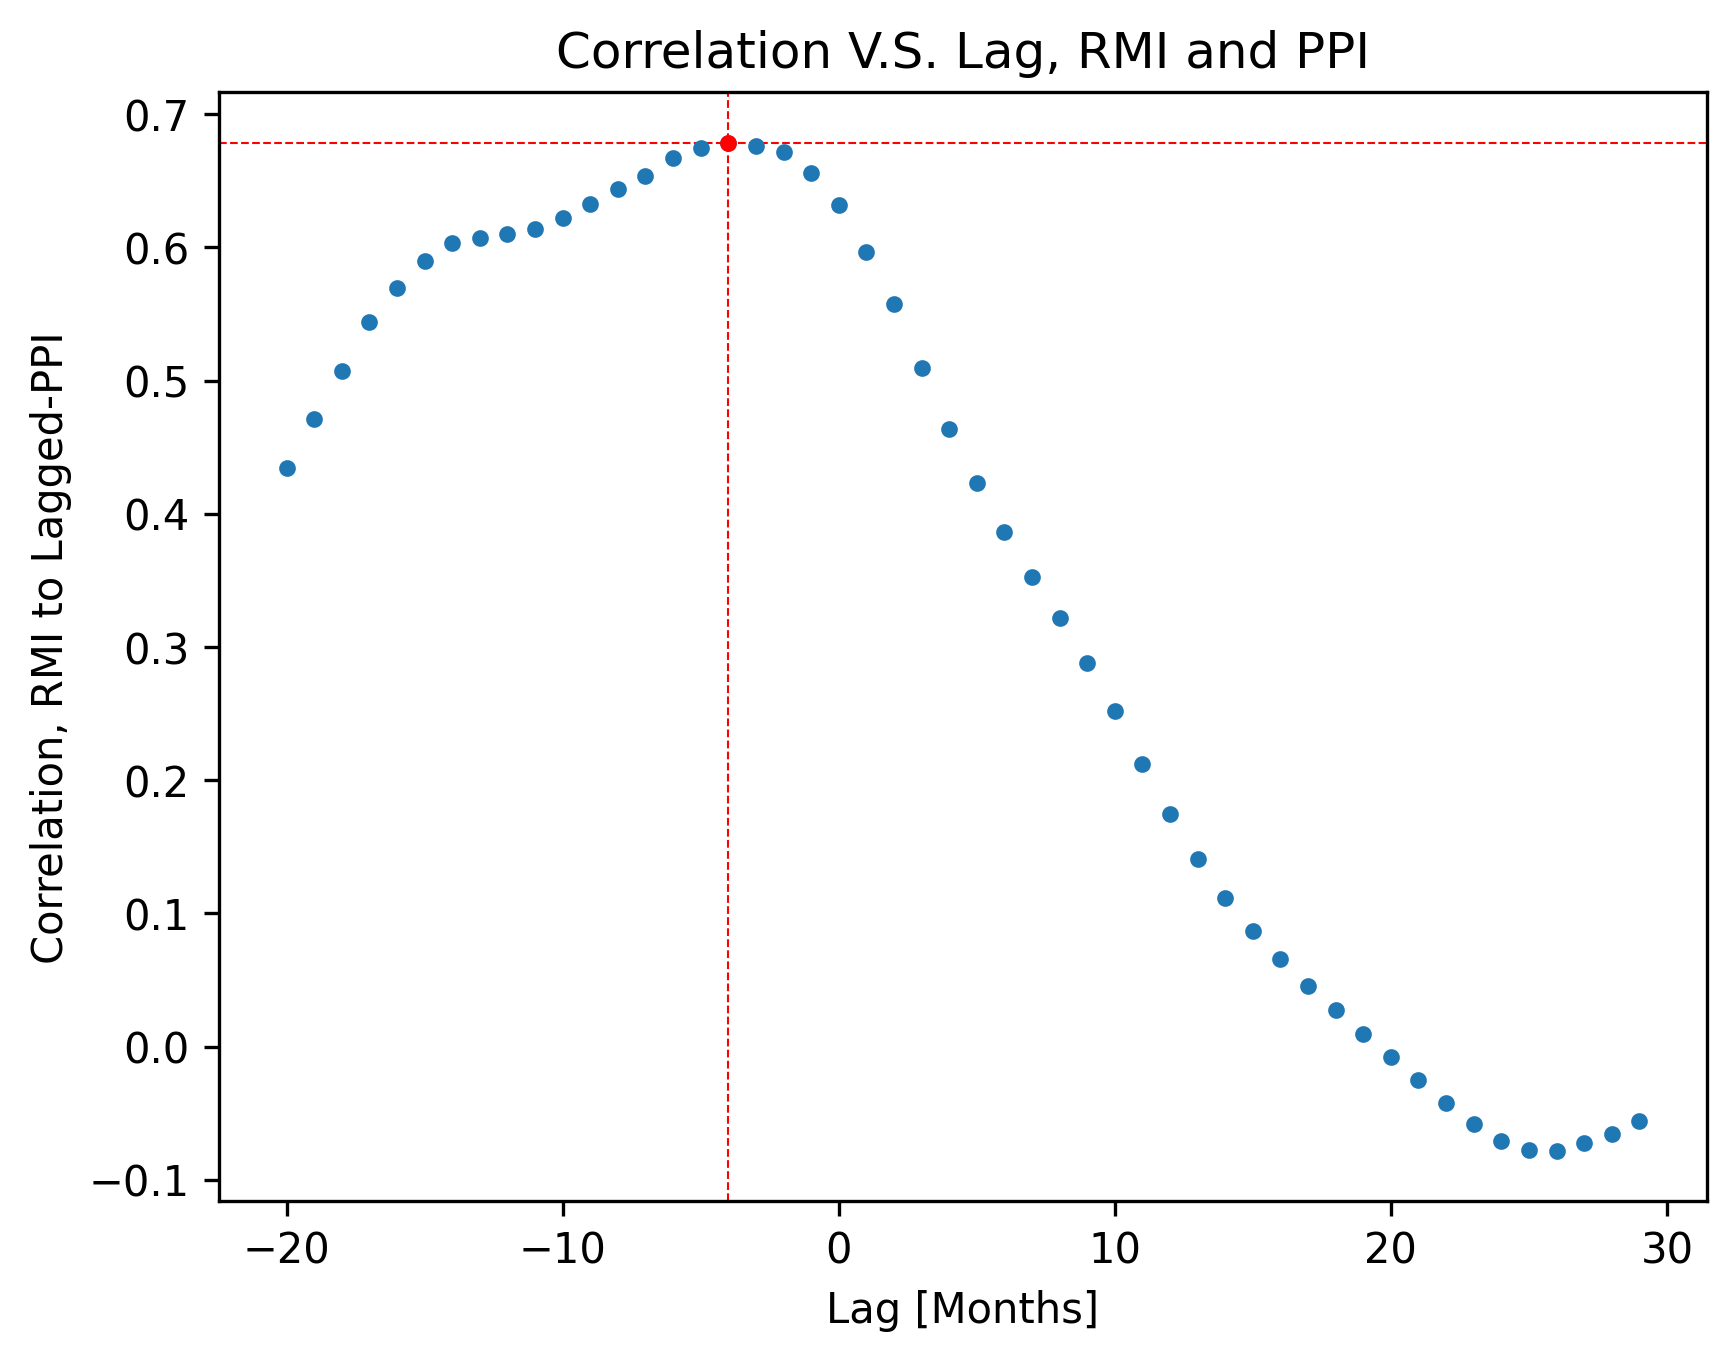

In [160]:
# plot correlation vs monthly lag
plt.figure(dpi=300)
plt.axvline(max_lag , linestyle="--", linewidth=0.5, color="red")
plt.axhline(max_corr, linestyle="--", linewidth=0.5, color="red")
plt.plot(lags, correlations, ".")
plt.plot([max_lag], [max_corr], ".r")
plt.title("Correlation V.S. Lag, RMI and PPI")
plt.xlabel("Lag [Months]")
plt.ylabel("Correlation, RMI to Lagged-PPI")
plt.show()

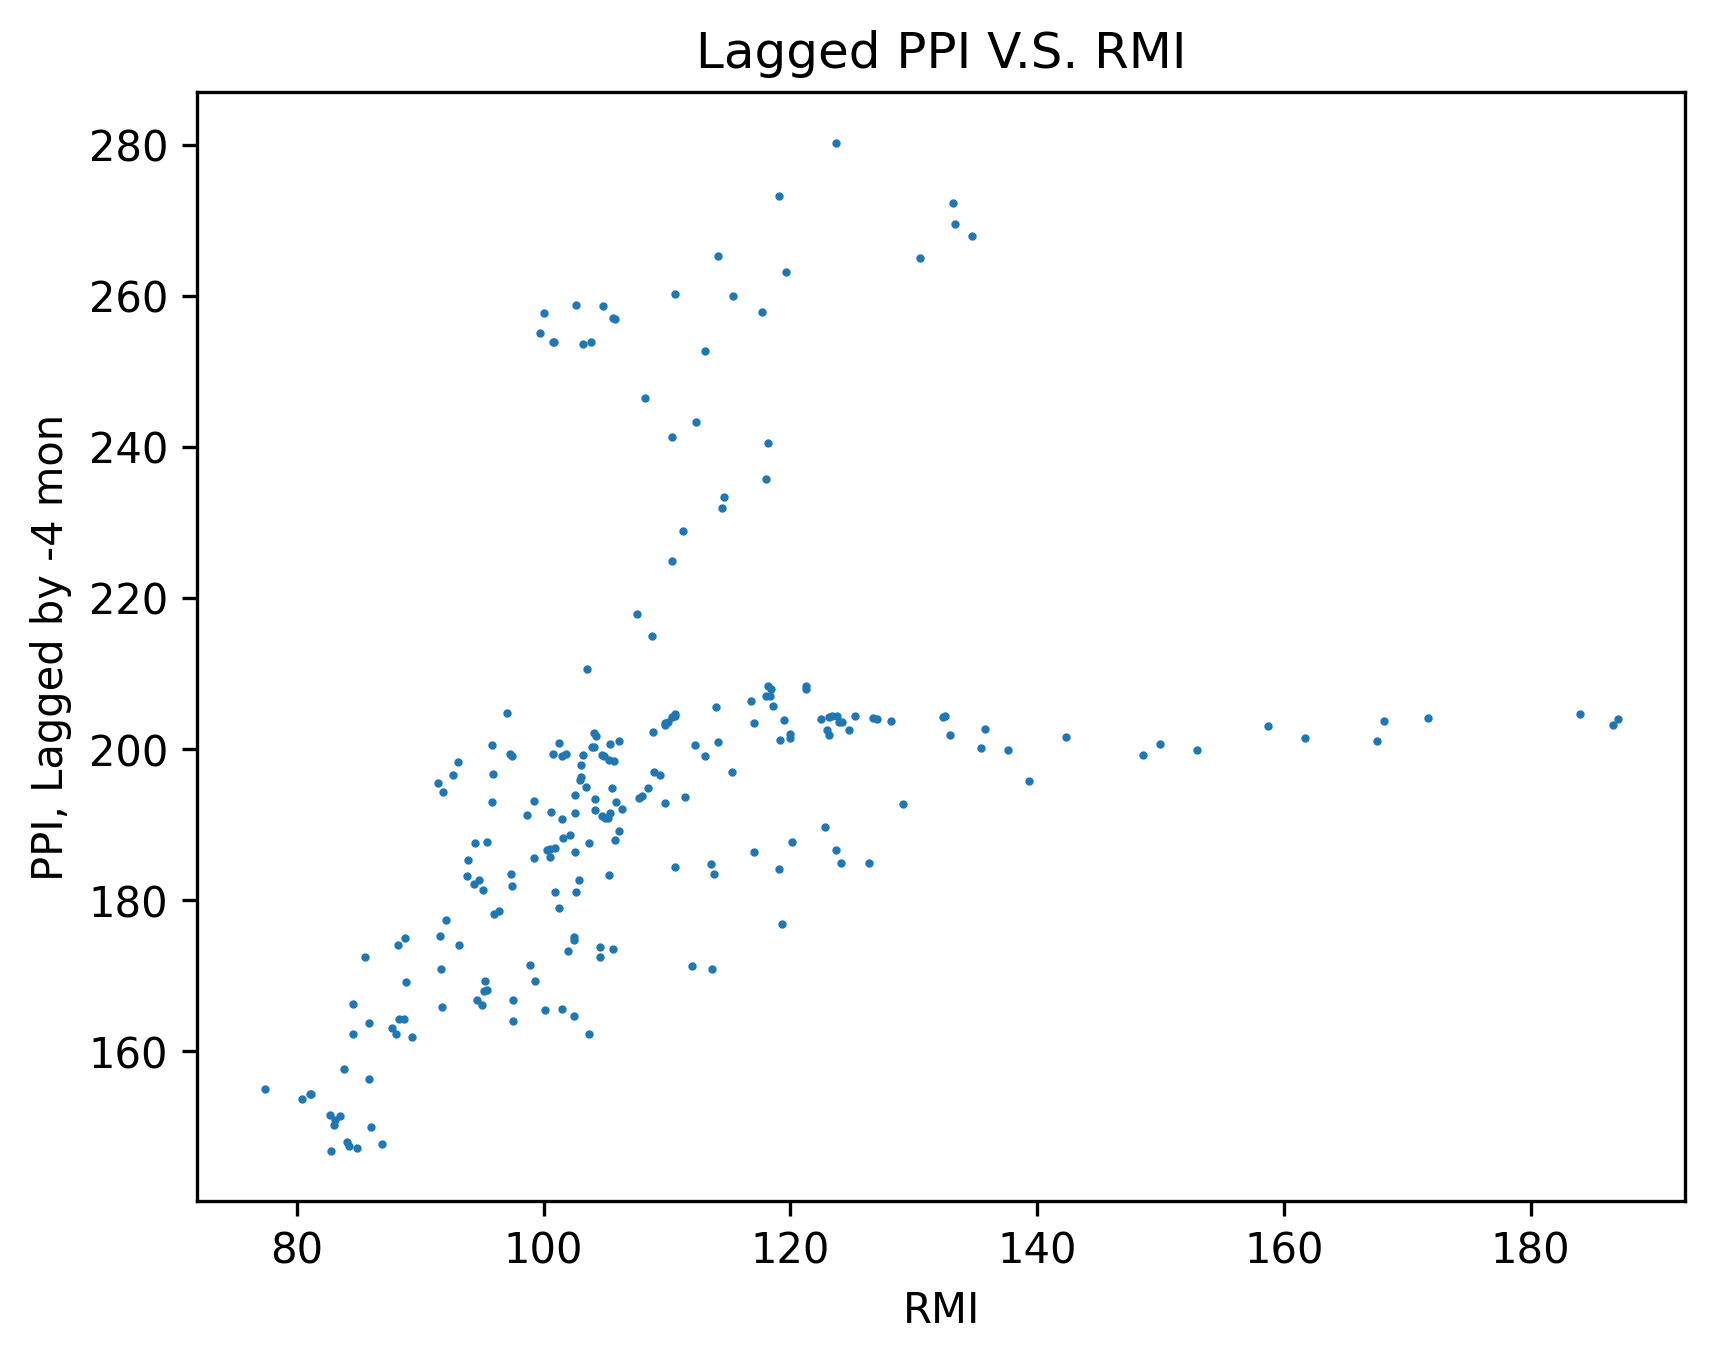

In [161]:
data_lags = pd.DataFrame(data_merged)

# shift ppi data by max_lag, dropping the NA values this creates
data_lags["ppi-lag-"+str(max_lag)] = data_merged["ppi"].shift(max_lag)
data_lags = data_lags.dropna()

plt.figure(dpi=300)
plt.scatter(data_lags["rmi"], data_lags["ppi-lag-"+str(max_lag)], s=1)
plt.title("Lagged PPI V.S. RMI")
plt.xlabel("RMI")
plt.ylabel("PPI, Lagged by "+str(max_lag)+" mon")
plt.show()

# note: data doens't seem too monotonic...

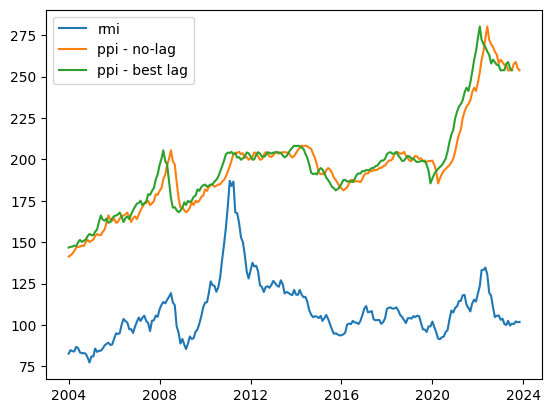

In [162]:
plt.plot(data_merged["rmi"], label="rmi")
plt.plot(data_merged["ppi"], label="ppi - no-lag")
plt.plot(data_lags["ppi-lag--4"], label="ppi - best lag")
plt.legend()

plt.show()

In [163]:
for index_name in ["moi", "rmi", "ppi"]:
    # initial value
    first_entry = data_merged[index_name].iloc[0]
    
    # add a new column with the % change since the initial value
    data_merged[index_name+"_delta%"] = (data_merged[index_name] / first_entry - 1) * 100

data_merged.head()

,rmi,ppi,moi,moi_delta%,rmi_delta%,ppi_delta%
2004-01-01,82.776881,141.4,164926.0,0.000000,0.000000,0.000000
2004-02-01,84.886602,142.1,180111.0,9.207160,2.548684,0.495050
2004-03-01,84.249977,143.1,214611.0,30.125632,1.779598,1.202263
2004-04-01,84.057943,144.8,183752.0,11.414816,1.547609,2.404526
2004-05-01,86.870517,146.8,181865.0,10.270667,4.945386,3.818953


In [164]:
# find correlations between MOI and RMI on % data
correlations_percent_data, lags, data_lags = calc_lagged_cor(data_merged, "rmi_delta%", "moi_delta%")
# find maximum correlation
max_corr = np.max(correlations_percent_data)
max_lag = lags[np.where(correlations_percent_data == max_corr)][0]

In [165]:
np.array(correlations) - np.array(correlations_percent_data)

array([0.36246616, 0.37240635, 0.38193683, 0.40669548, 0.40316238,
       0.41211559, 0.42578081, 0.42614812, 0.4256854 , 0.42284652,
       0.41168487, 0.41273851, 0.42373896, 0.42001207, 0.42173312,
       0.41980487, 0.40321984, 0.39128908, 0.4026452 , 0.38257424,
       0.37702922, 0.35923495, 0.33604748, 0.31332914, 0.30906706,
       0.30376124, 0.3067149 , 0.30328025, 0.30633369, 0.31108409,
       0.32899474, 0.33807496, 0.35352049, 0.35520008, 0.35579646,
       0.36238007, 0.38848255, 0.38672193, 0.38639795, 0.38929256,
       0.37311332, 0.36145511, 0.37184963, 0.35702522, 0.34448676,
       0.34026645, 0.30686014, 0.28593769, 0.2847161 , 0.24817828])

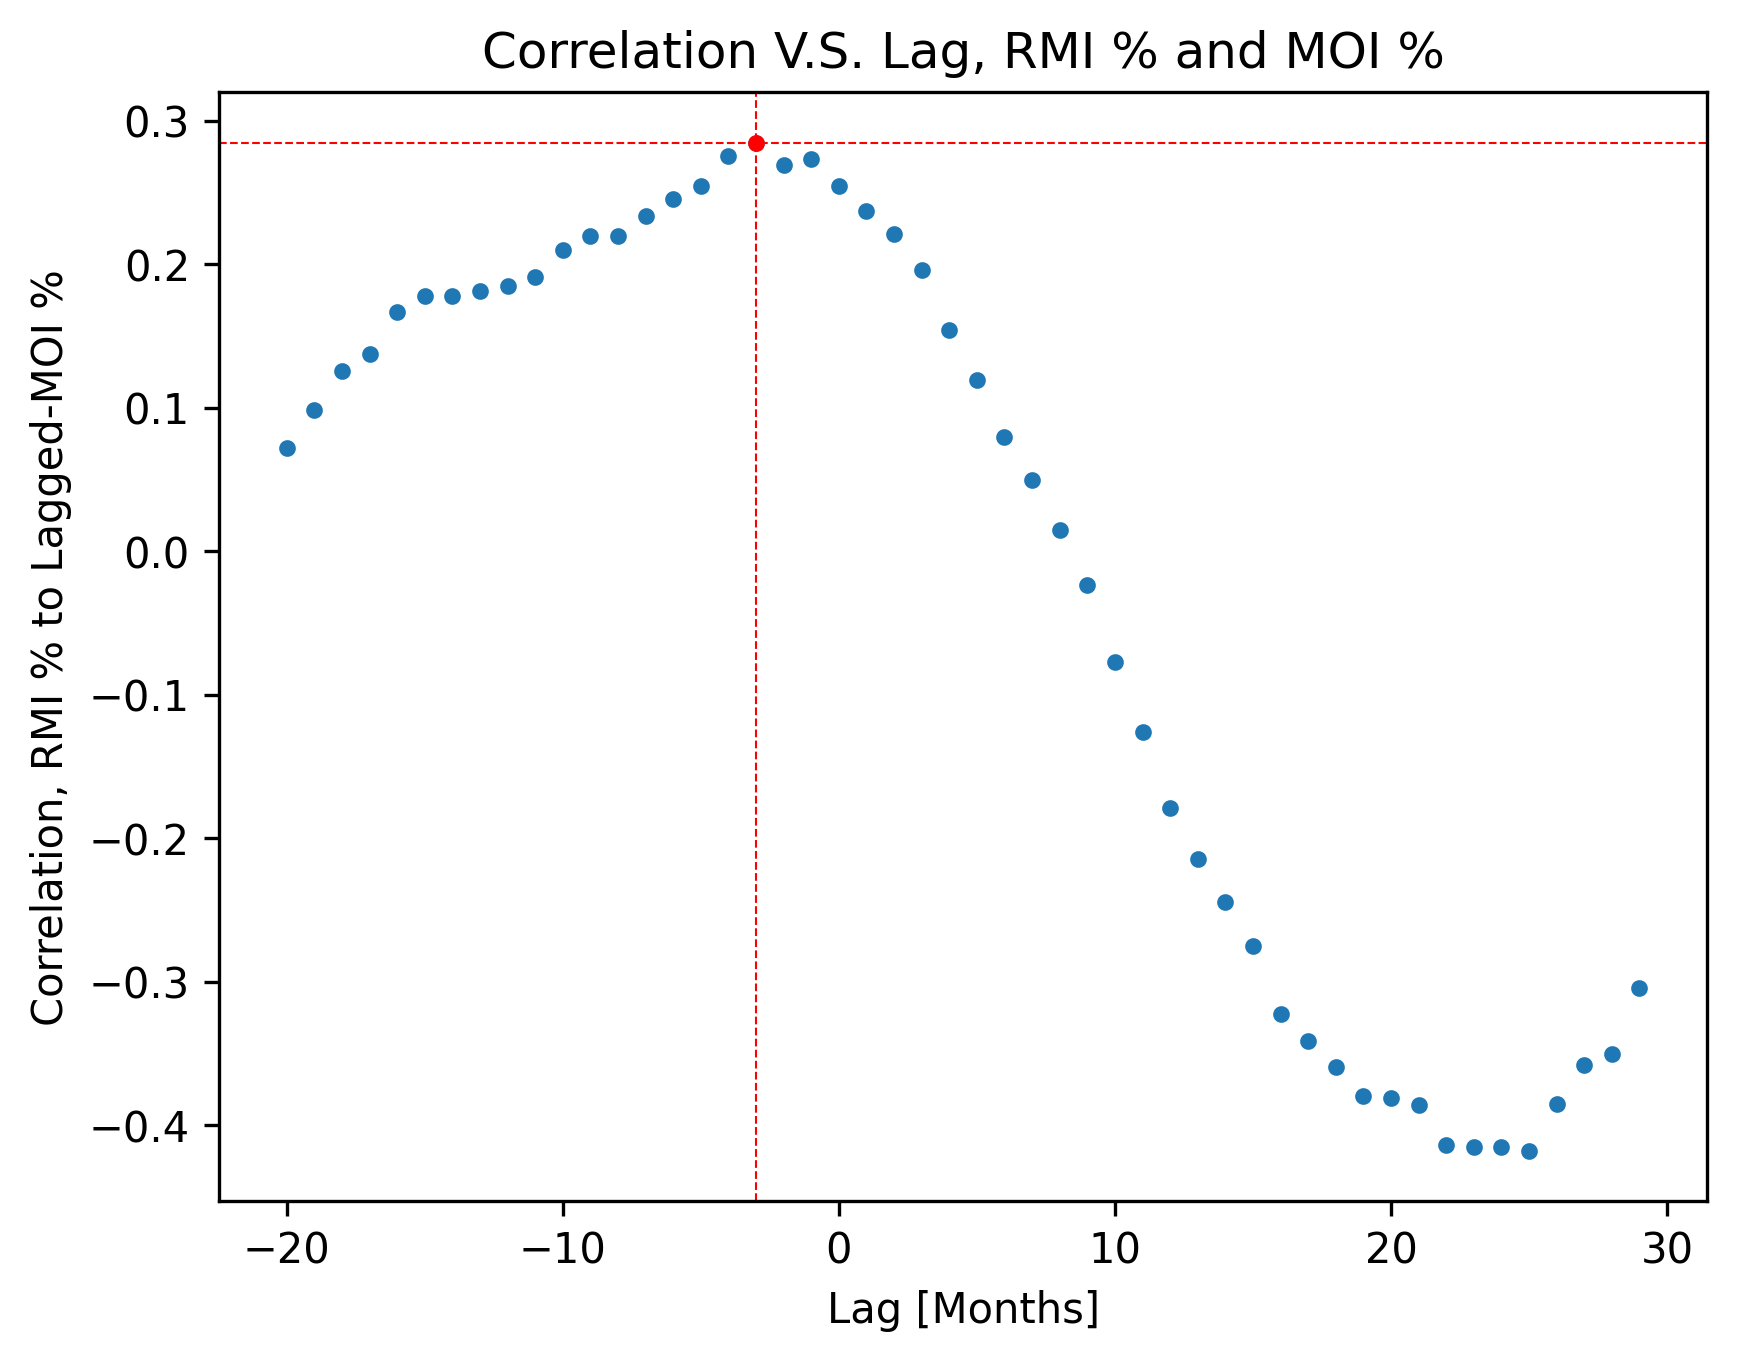

In [166]:
# plot correlation vs monthly lag
plt.figure(dpi=300)
plt.axvline(max_lag , linestyle="--", linewidth=0.5, color="red")
plt.axhline(max_corr, linestyle="--", linewidth=0.5, color="red")
plt.plot(lags, correlations_percent_data, ".")
plt.plot([max_lag], [max_corr], ".r")
plt.title("Correlation V.S. Lag, RMI % and MOI %")
plt.xlabel("Lag [Months]")
plt.ylabel("Correlation, RMI % to Lagged-MOI %")
plt.show()

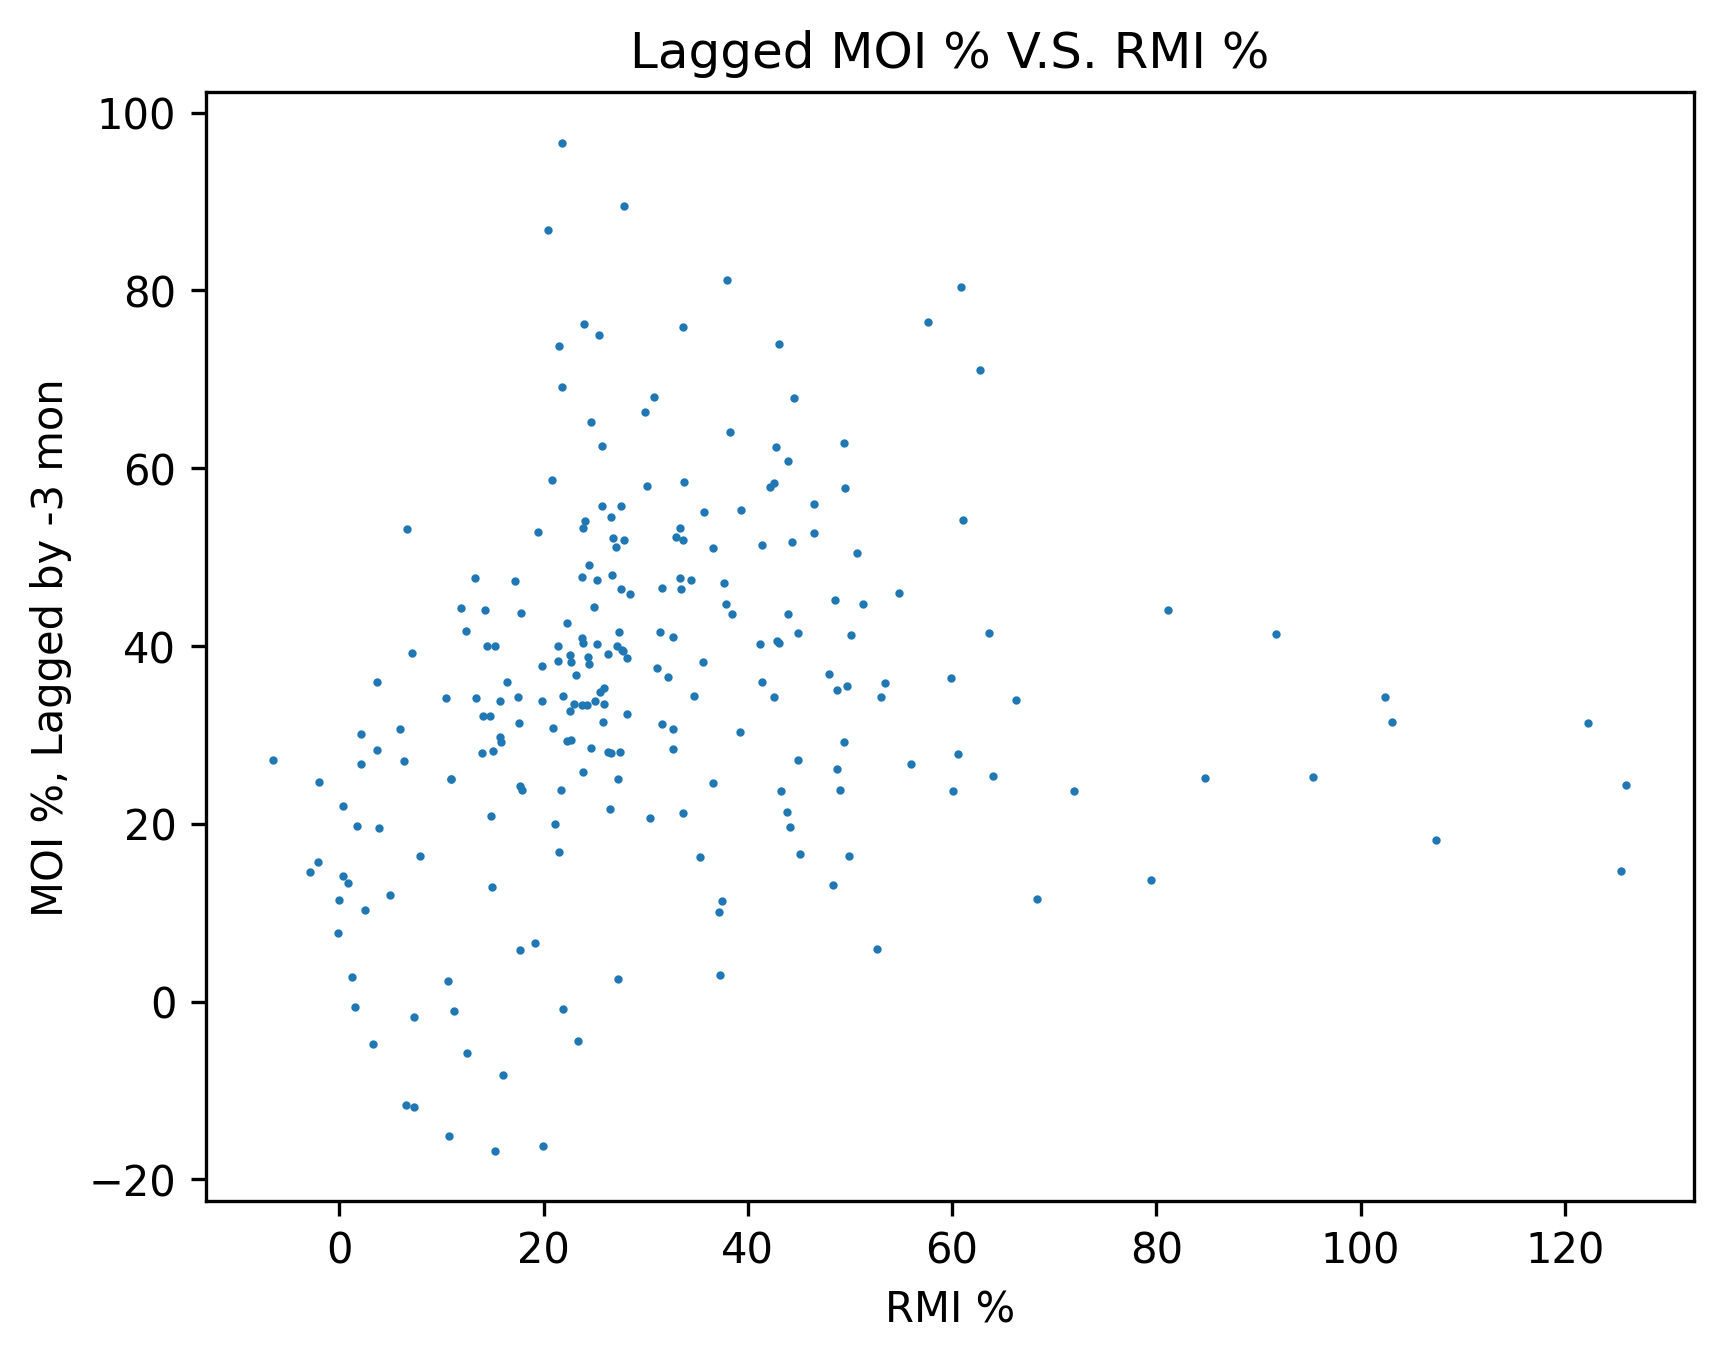

In [167]:
data_lags = pd.DataFrame(data_merged)

# shift ppi data by max_lag, dropping the NA values this creates
data_lags["moi_delta%-lag-"+str(max_lag)] = data_merged["moi_delta%"].shift(max_lag)
data_lags = data_lags.dropna()

plt.figure(dpi=300)
plt.scatter(data_lags["rmi_delta%"], data_lags["moi_delta%-lag-"+str(max_lag)], s=1)
plt.title("Lagged MOI % V.S. RMI %")
plt.xlabel("RMI %")
plt.ylabel("MOI %, Lagged by "+str(max_lag)+" mon")
plt.show()

# note: has not changed at all from previous result.

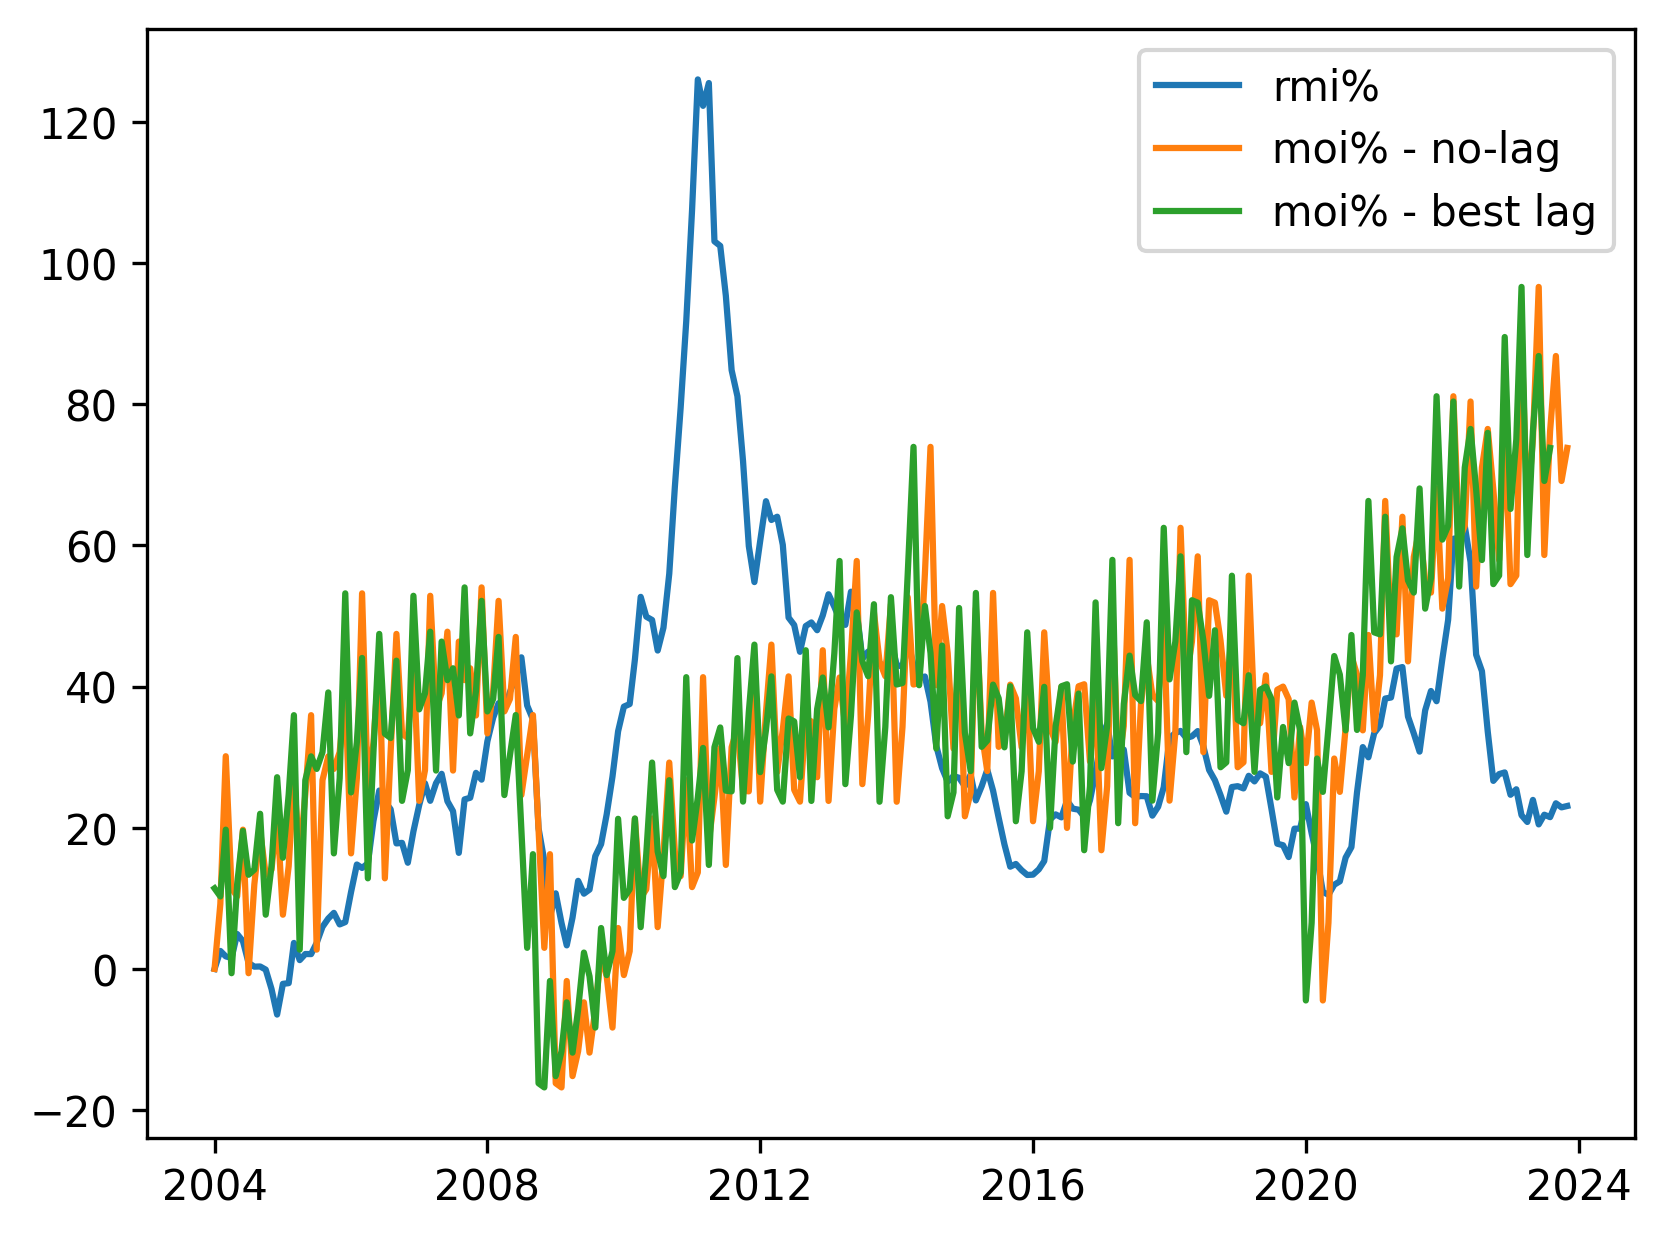

In [170]:
plt.figure(dpi=300)
plt.plot(data_merged["rmi_delta%"], label="rmi%")
plt.plot(data_merged["moi_delta%"], label="moi% - no-lag")
plt.plot(data_lags["moi_delta%-lag--3"], label="moi% - best lag")
plt.legend()

plt.show()

### 3 -- Feature transformations

In [121]:
from statsmodels.tsa.stattools import adfuller

# perform the Augmented Dickey Fuller test
# second value is p-value, null hypothesis being non-stationarity
adfuller(data_ppi['value'])

0.618057354538128

In [119]:
adfuller(data_rmi['value'])

(-3.125558108244732,
 0.024718686912832837,
 2,
 236,
 {'1%': -3.4583663275730476,
  '5%': -2.8738660999177132,
  '10%': -2.5733390785693766},
 1191.989624930655)

In [128]:
# note: ppi data has a very high p-value, so null hypothesis is likely true
print("PPI has p-value of ", round(adfuller(data_ppi['value'])[1],3), "so the series is non-stationary.")
print("RMI has p-value of ", round(adfuller(data_rmi['value'])[1],3), "so the series is     stationary.")

PPI has p-value of  0.618 so the series is non-stationary.
RMI has p-value of  0.025 so the series is     stationary.


RMI has p-value of  0.385 so the series is now *non-stationary*.


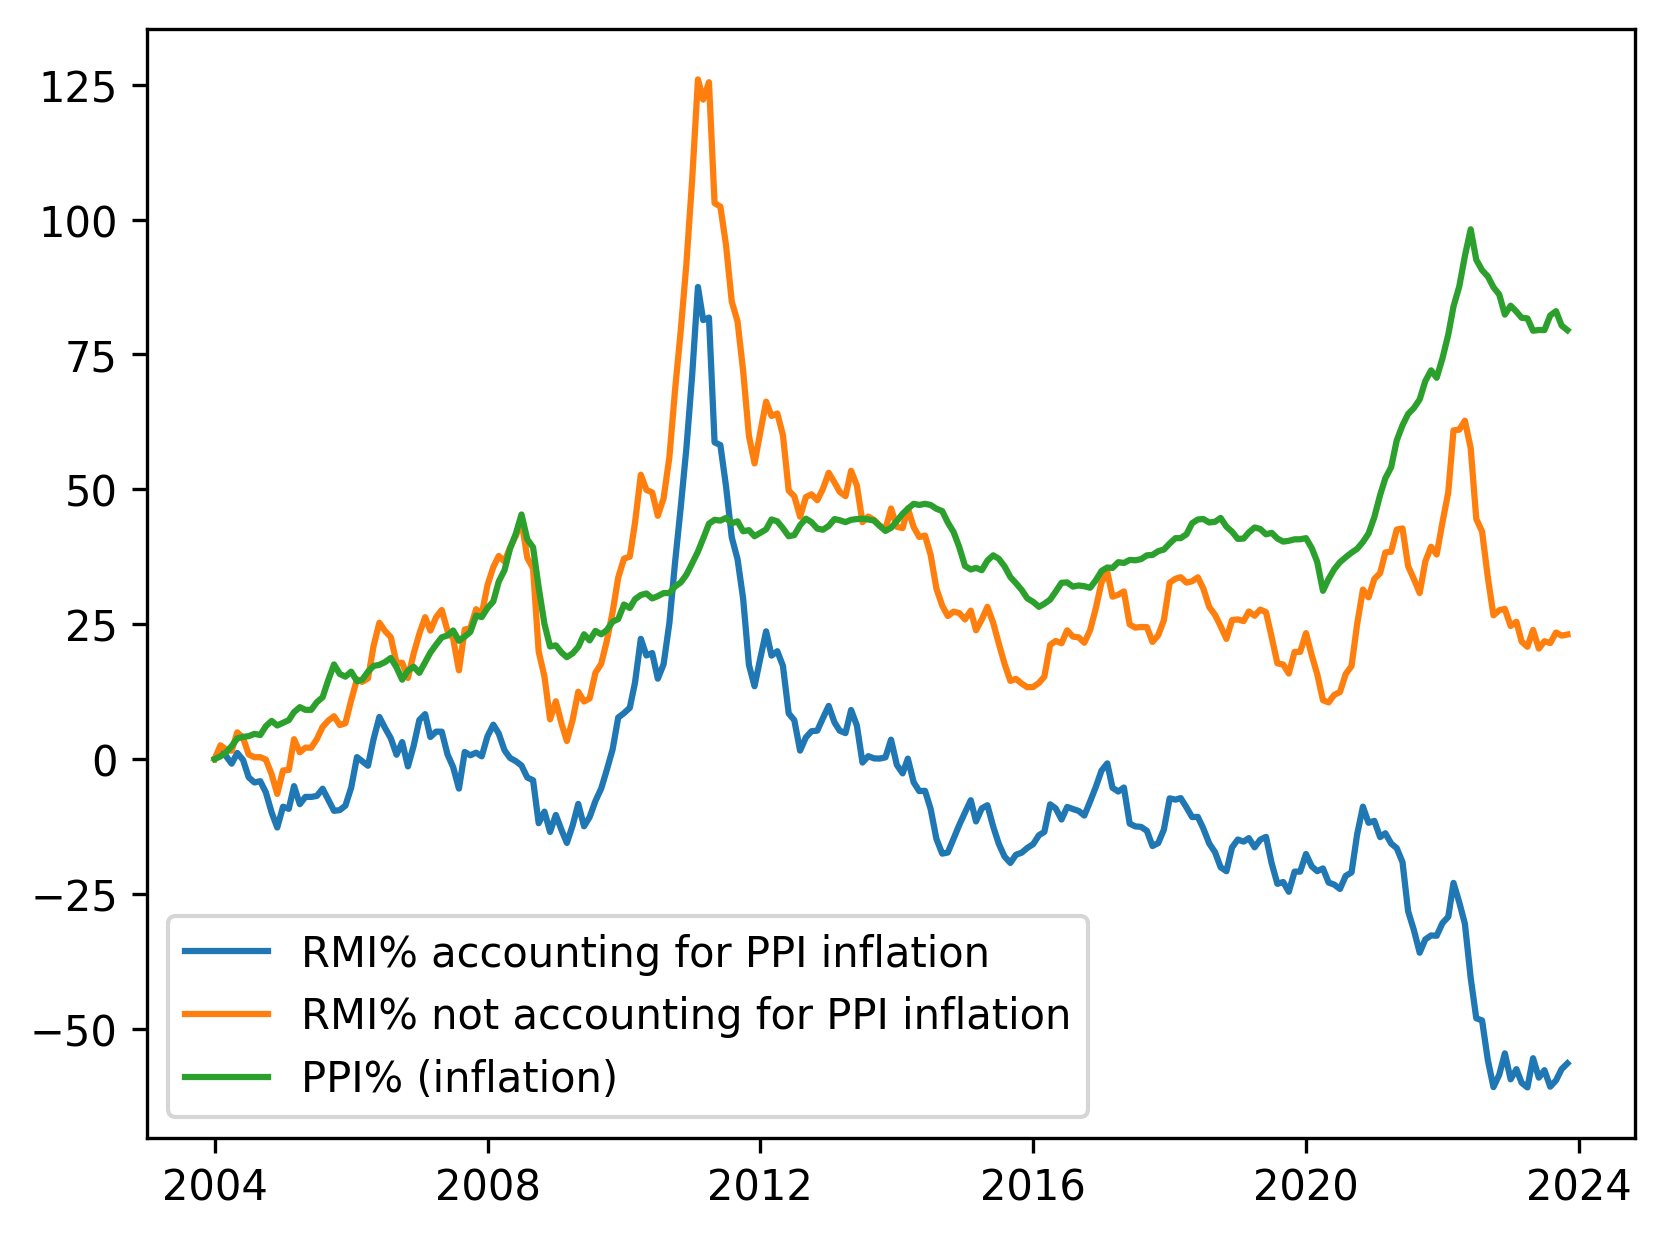

In [171]:
# Now, let's adjust RMI for PPI inflation and try again.
# calculate % changes again
data_rmi["%"] = (data_rmi["value"] / data_rmi["value"].iloc[0] - 1) * 100
data_ppi["%"] = (data_ppi["value"] / data_ppi["value"].iloc[0] - 1) * 100
data_moi["%"] = (data_moi["value"] / data_moi["value"].iloc[0] - 1) * 100

data_rmi["%-with-ppi-inflation"] = data_rmi["%"] - data_ppi["%"]

print("RMI has p-value of ", round(adfuller(data_rmi["%-with-ppi-inflation"])[1],3), "so the series is now *non-stationary*.")

plt.figure(dpi=300)
plt.plot(data_rmi["%-with-ppi-inflation"], label="RMI% accounting for PPI inflation")
plt.plot(data_rmi["%"], label="RMI% not accounting for PPI inflation")
plt.plot(data_ppi["%"], label="PPI% (inflation)")
plt.legend()
plt.show()

# makes more sense now -- inflation went up a LOT since ~2020, but the price of materials actually decreased.

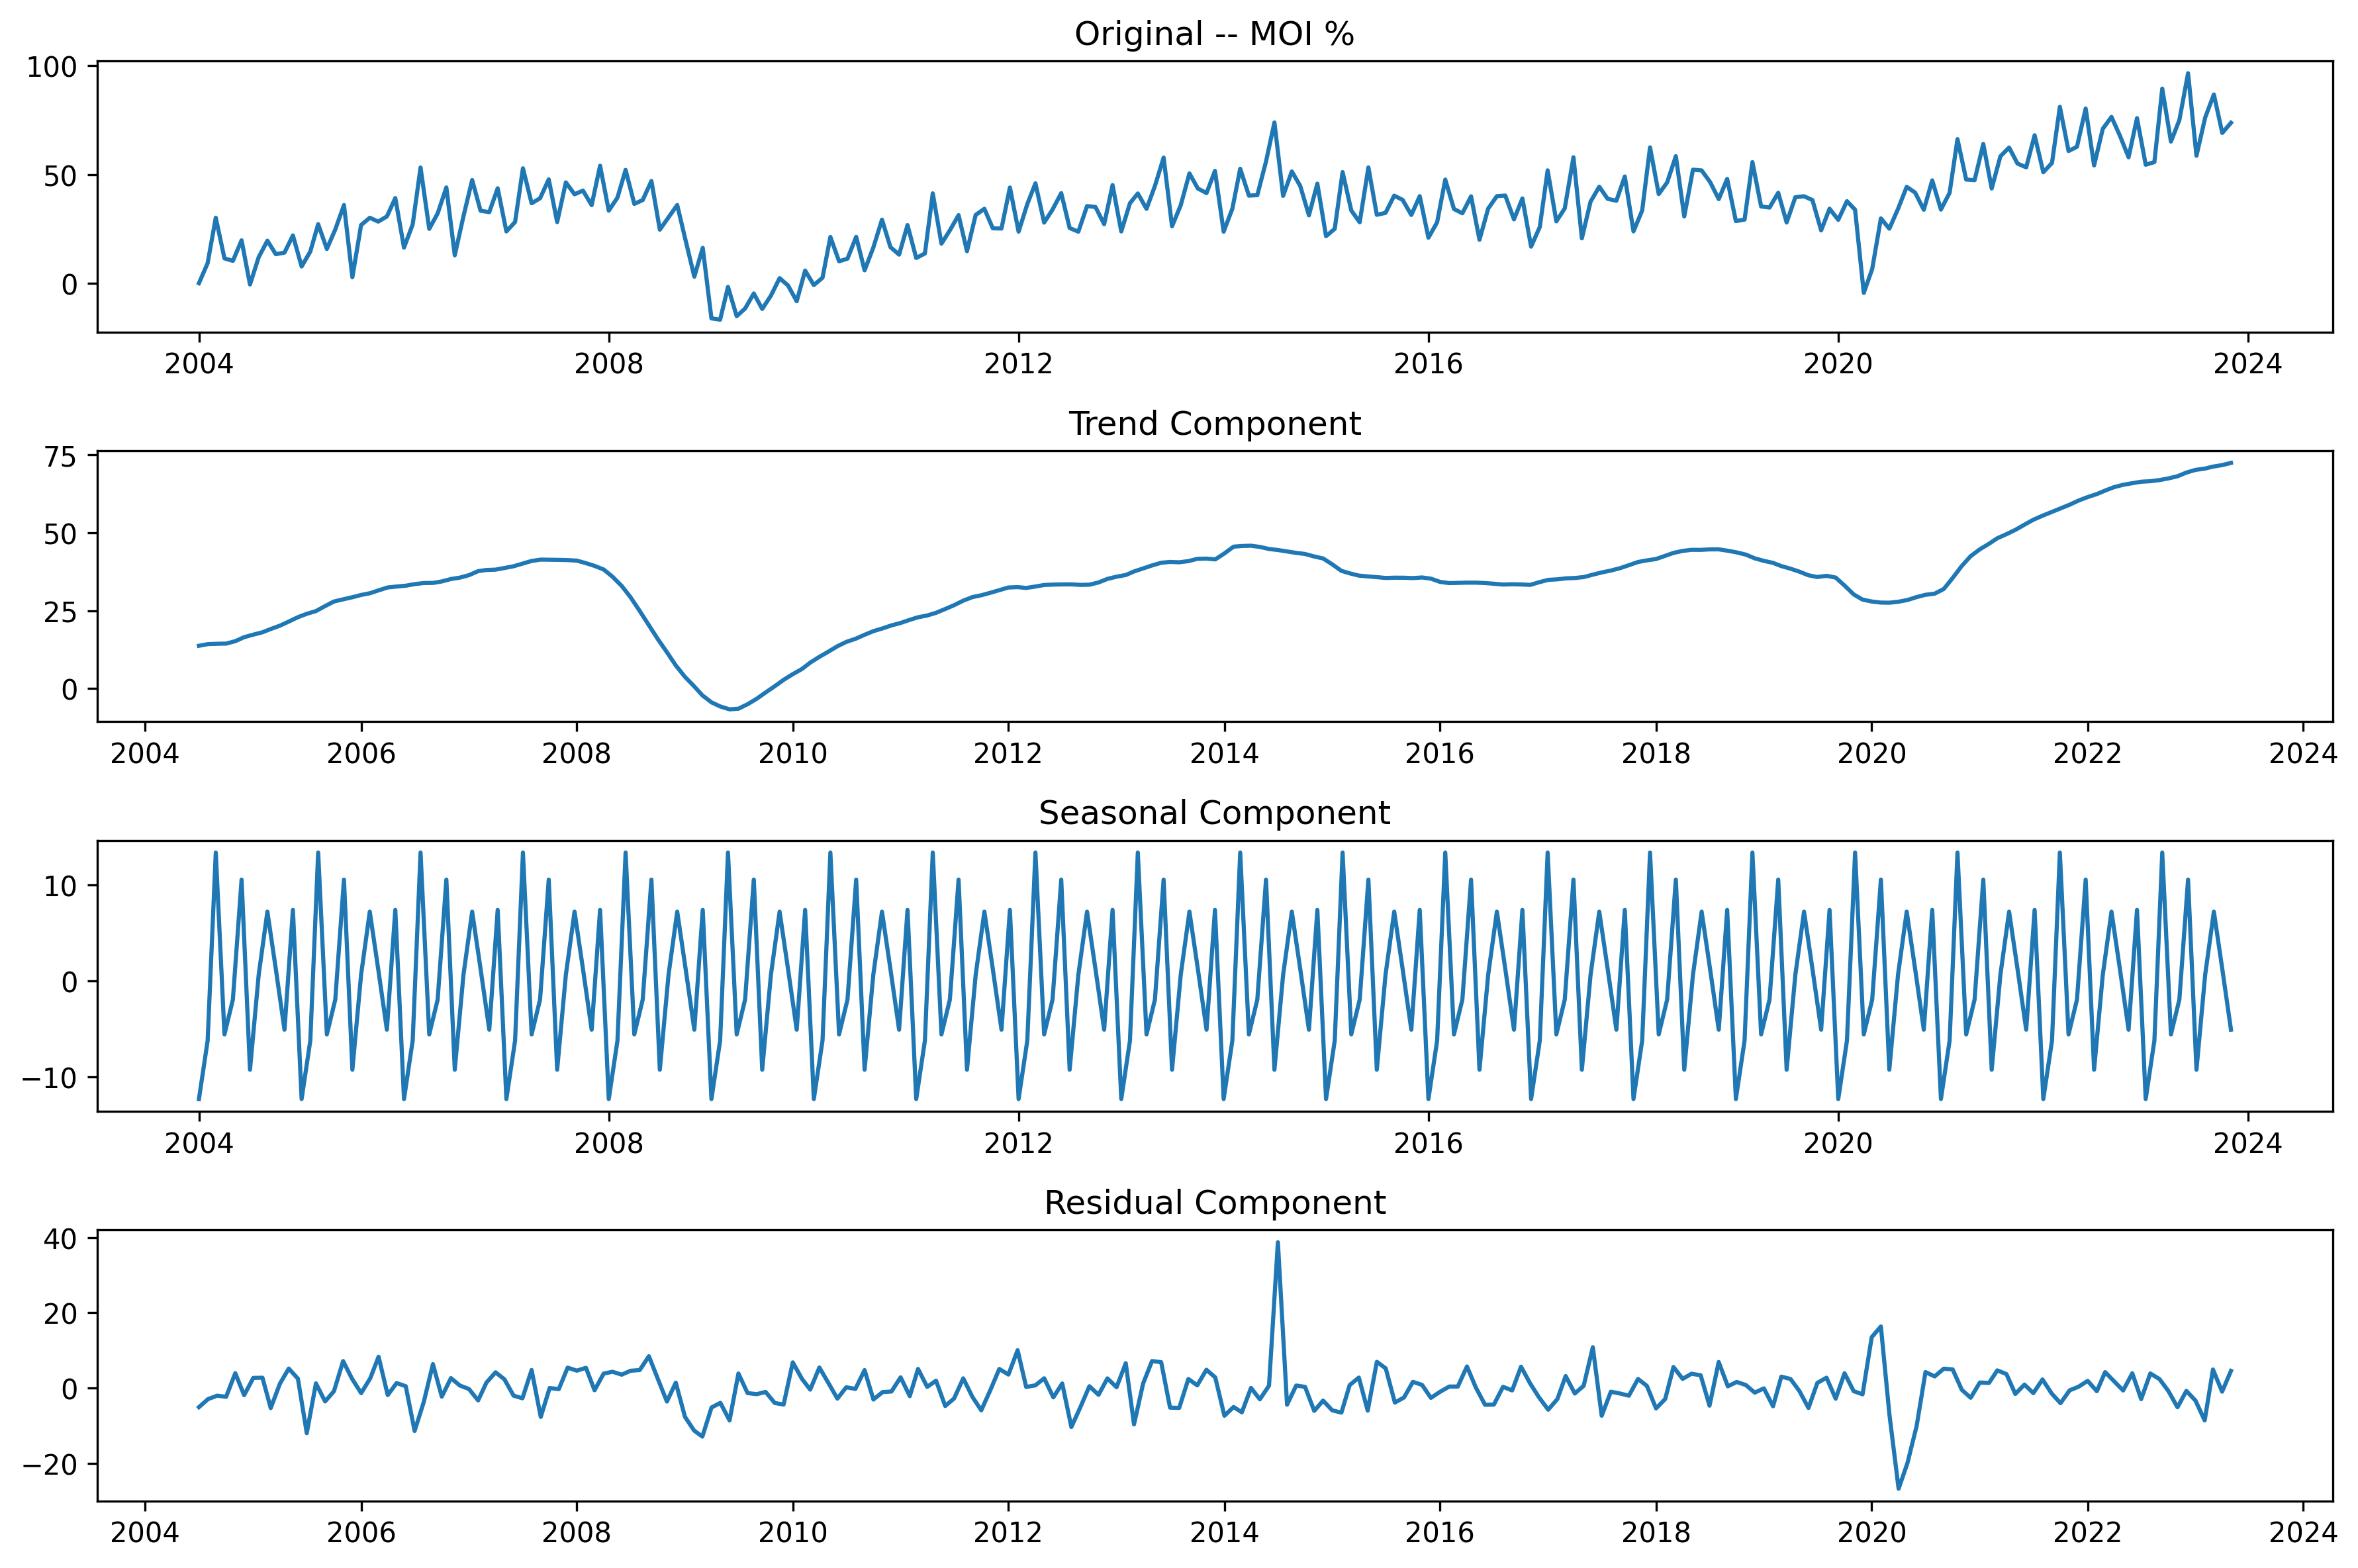

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose the trend and seasonality from the adjusted MOI data
res = seasonal_decompose(data_moi["%"], model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
# Access the components
trend = res.trend
seasonal = res.seasonal
residual = res.resid

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8), dpi=300)

plt.subplot(4, 1, 1)
plt.plot(data_moi['%'])
plt.title('Original -- MOI %')

plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(residual)
plt.title('Residual Component')

plt.tight_layout()
plt.show()

In [33]:
plt.figure(dpi=300)
plt.scatter()

plt.scatter(merged_data_cleaned['value_rmi'], merged_data_cleaned['value_ppi_lagged'])
plt.title(f'Scatter Plot with Lag {optimal_lag}')
plt.xlabel('Raw Materials Index (RMI)')
plt.ylabel(f'Producer Price Index (PPI) Lagged by {optimal_lag} months')
plt.show()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

<Figure size 1920x1440 with 0 Axes>

In [ ]:
# Merge data on the 'date' column
merged_data = pd.merge(data_rmi, data_ppi, on='date')

# Calculate Spearman autocorrelation with lags from 1 to 30 months
lags = range(1, 31)
correlations = []

for lag in lags:
    # Calculate lagged values
    merged_data['value_ppi_lagged'] = merged_data['value_ppi'].shift(lag)
    
    # Remove rows with NaN resulting from shifting
    merged_data_cleaned = merged_data.dropna()
    
    # Calculate Spearman correlation
    correlation, _ = spearmanr(merged_data_cleaned['value_rmi'], merged_data_cleaned['value_ppi_lagged'])
    correlations.append(correlation)

# Create a DataFrame with lag and correlation values
result_df = pd.DataFrame({'Lag': lags, 'SpearmanCorrelation': correlations})

# Print or further process the result DataFrame
print(result_df)

In [17]:
list(data_rmi.columns[0])
# data_rmi

['D', 'a', 't', 'e']